In [1]:
import pandas as pd
import numpy as np

# 1. Define file names
files = {
    "events": "events.csv",
    "users": "users.csv",
    "subscriptions": "subscriptions.csv",
    "marketing": "marketing_spend.csv"
}

# 2. Load the data into a dictionary of DataFrames
dataframes = {}

try:
    for name, file_name in files.items():
        dataframes[name] = pd.read_csv(file_name)
        print(f"Successfully loaded {file_name}")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please check that the CSV files are in the same folder as this notebook.")

print("-" * 30)

for name, df in dataframes.items():
    print(f"### DataFrame: {name} ###")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print("\nFirst 5 rows:")
    display(df.head())
    print("-" * 30)

Successfully loaded events.csv
Successfully loaded users.csv
Successfully loaded subscriptions.csv
Successfully loaded marketing_spend.csv
------------------------------
### DataFrame: events ###
Shape: (277009, 5)
Columns: ['user_id', 'event_time', 'event_name', 'platform', 'session_id']

First 5 rows:


,user_id,event_time,event_name,platform,session_id
0,U00001,2024-02-08 00:00:00,signup,web,S_U00001_1
1,U00001,2024-02-08 01:00:00,code_run,web,S_U00001_1
2,U00001,2024-02-09 00:00:00,deploy,web,S_U00001_2
3,U00001,2024-02-18 00:00:00,upgrade,web,S_U00001_4
4,U00002,2024-02-21 00:00:00,signup,web,S_U00002_1


------------------------------
### DataFrame: users ###
Shape: (100000, 5)
Columns: ['user_id', 'signup_date', 'country', 'persona', 'acquisition_channel']

First 5 rows:


,user_id,signup_date,country,persona,acquisition_channel
0,U00001,2024-02-08,India,team,email
1,U00002,2024-02-21,UK,student,organic
2,U00003,2024-01-29,India,student,paid_ads
3,U00004,2024-01-15,USA,team,paid_ads
4,U00005,2024-02-12,India,student,email


------------------------------
### DataFrame: subscriptions ###
Shape: (18021, 5)
Columns: ['user_id', 'plan_type', 'start_date', 'mrr', 'churned']

First 5 rows:


,user_id,plan_type,start_date,mrr,churned
0,U00002,pro,2024-01-23,40,False
1,U00003,pro,2024-01-24,20,True
2,U00012,team,2024-01-13,40,False
3,U00026,pro,2024-01-28,20,False
4,U00027,team,2024-01-17,20,False


------------------------------
### DataFrame: marketing ###
Shape: (244, 3)
Columns: ['date', 'channel', 'spend']

First 5 rows:


,date,channel,spend
0,2024-01-01,organic,242
1,2024-01-01,paid_ads,278
2,2024-01-01,email,307
3,2024-01-01,referral,289
4,2024-01-02,organic,374


------------------------------


In [2]:
events = dataframes['events']

# 1. Filter users who have performed the 'code_run' event
# We filter by the specific string 'code_run' found in the event_name column
code_run_events = events[events['event_name'] == 'code_run']

# 2. Create a DataFrame with unique user_id for these users
# We use .unique() because a single user might run code multiple times,
# but we only want to count them once as an eligible participant.
unique_ids = code_run_events['user_id'].unique()
eligible_population = pd.DataFrame(unique_ids, columns=['user_id'])

# 3. Print the total number of users eligible for the experiment
print(f"Total users eligible for the A/B test: {len(eligible_population)}")

display(eligible_population.head())

Total users eligible for the A/B test: 85071


,user_id
0,U00001
1,U00002
2,U00003
3,U00004
4,U00005


In [3]:
np.random.seed(42)
# 'A' = Control (Current Experience)
# 'B' = Variant (New Feature)
eligible_population['experiment_group'] = np.random.choice(
    ['A', 'B'], 
    size=len(eligible_population), 
    p=[0.5, 0.5]  # 50% split
)

#. Show the count of users in each group
print("Experiment Group Counts:")
print(eligible_population['experiment_group'].value_counts())

# Check the percentage split
print("\nSplit Percentage:")
print(eligible_population['experiment_group'].value_counts(normalize=True))

display(eligible_population.head())

Experiment Group Counts:
experiment_group
B    42644
A    42427
Name: count, dtype: int64

Split Percentage:
experiment_group
B    0.501275
A    0.498725
Name: proportion, dtype: float64


,user_id,experiment_group
0,U00001,A
1,U00002,B
2,U00003,B
3,U00004,B
4,U00005,A


In [4]:
# 1. Merge the experiment group DataFrame with the full events DataFrame
# ---------------------------------------------------------------------
# WHY THIS MERGE IS NECESSARY:
# The 'eligible_population' DataFrame only tells us WHICH group a user is in (A or B).
# The 'events' DataFrame tells us WHAT they actually did (clicks, upgrades, etc.).
# By merging them, we can answer questions like:
# "Did users in Group B perform the 'upgrade' event more often than Group A?"
# ---------------------------------------------------------------------

# We use an 'inner' merge here implicitly (default).
# This effectively keeps only the events for users who are actually in our experiment.
experiment_data = pd.merge(eligible_population, events, on='user_id')

# 2. Create a new DataFrame with specific columns
experiment_logs = experiment_data[['user_id', 'experiment_group', 'event_name']]

# 3. Display a few sample rows to verify the merge
print(f"Shape of merged data: {experiment_logs.shape}")
display(experiment_logs.sample(5)) # using sample() gives a random look at the data

Shape of merged data: (248338, 3)


,user_id,experiment_group,event_name
23867,U09700,A,signup
35257,U14262,B,code_run
140195,U56551,A,signup
184535,U74353,B,code_run
163479,U65948,A,signup


In [5]:
# 1. Create a summary table counting unique users for each event
# ---------------------------------------------------------------------
# EXPLANATION OF METRIC:
# The "Deployment Conversion Rate" measures the funnel efficiency.
# 'code_run' represents users attempting to use the product (Intent).
# 'deploy' represents users achieving the core value proposition (Success).
# A higher conversion rate in Group B would indicate that the new feature
# successfully helps more users cross the finish line from "trying" to "succeeding".
# ---------------------------------------------------------------------

# We use pivot_table to organize the data:
# - index: The rows will be our groups (A and B)
# - columns: The columns will be the different event names
# - values: We count the 'user_id'
# - aggfunc: We use 'nunique' to count UNIQUE users (ignoring repeat actions)
conversion_summary = experiment_logs.pivot_table(
    index='experiment_group', 
    columns='event_name', 
    values='user_id', 
    aggfunc='nunique'
)

# We only need the 'code_run' and 'deploy' columns for this specific calculation
conversion_summary = conversion_summary[['code_run', 'deploy']]

# 2. Calculate deployment conversion rate for each group
conversion_summary['conversion_rate'] = conversion_summary['deploy'] / conversion_summary['code_run']

# Optional: Make it look nice (convert to percentage)
conversion_summary['conversion_rate_pct'] = (conversion_summary['conversion_rate'] * 100).round(2)

# 3. Display the results
print("A/B Test Results - Deployment Conversion:")
display(conversion_summary)

A/B Test Results - Deployment Conversion:


event_name,code_run,deploy,conversion_rate,conversion_rate_pct
experiment_group,,,,
A,42427,21310,0.502274,50.23
B,42644,21274,0.498874,49.89


In [6]:
from scipy.stats import chi2_contingency

# 1. Construct the contingency table from your data
# Rows: Group A, Group B
# Cols: Converted (Deployed), Not Converted (Did not Deploy)
# Not Converted = Total code_runs - Deployed

# Group A
a_total = 42427
a_converted = 21310
a_not_converted = a_total - a_converted

# Group B
b_total = 42644
b_converted = 21274
b_not_converted = b_total - b_converted

observed = [
    [a_converted, a_not_converted],
    [b_converted, b_not_converted]
]

# 2. Run Chi-Square Test
chi2, p_value, dof, expected = chi2_contingency(observed)

print(f"P-Value: {p_value:.4f}")

# 3. Interpret the result
alpha = 0.05 # Standard 5% significance level
if p_value < alpha:
    print("Result is Statistically Significant.")
    print("Conclusion: The drop in Group B is REAL. The new feature hurt performance.")
else:
    print("Result is NOT Statistically Significant.")
    print("Conclusion: The difference is likely due to chance. The new feature had no measurable impact.")

P-Value: 0.3247
Result is NOT Statistically Significant.
Conclusion: The difference is likely due to chance. The new feature had no measurable impact.


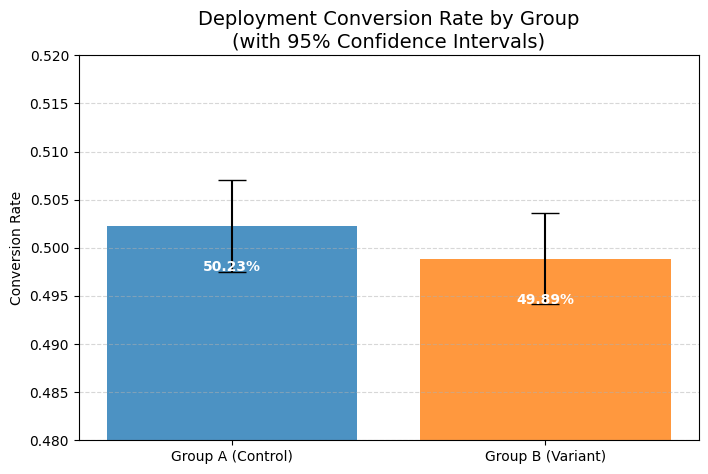

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Setup the data
groups = ['Group A (Control)', 'Group B (Variant)']
conversion_rates = [0.502274, 0.498874] # From your previous output
sample_sizes = [42427, 42644]           # Total users in each group

# 2. Calculate Standard Error (SE) for Error Bars
# Formula: SE = sqrt( p * (1-p) / n )
errors = []
for p, n in zip(conversion_rates, sample_sizes):
    se = np.sqrt((p * (1 - p)) / n)
    errors.append(1.96 * se) # 95% Confidence Interval (1.96 standard deviations)

# 3. Create the Bar Chart
plt.figure(figsize=(8, 5))
# yerr=errors adds the error bars
bars = plt.bar(groups, conversion_rates, yerr=errors, capsize=10, color=['#1f77b4', '#ff7f0e'], alpha=0.8)

# 4. Add formatting
plt.title('Deployment Conversion Rate by Group\n(with 95% Confidence Intervals)', fontsize=14)
plt.ylabel('Conversion Rate')
plt.ylim(0.48, 0.52) # Zoom in to see the difference (or lack thereof)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add text labels on the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height - 0.005,
             f'{height:.2%}', ha='center', va='bottom', color='white', fontweight='bold')

plt.show()

In [9]:
users = pd.read_csv('users.csv')
# 1. Merge with Users table to get 'persona'
# We perform a 'left' merge to keep all our experiment users and just add their persona info.
experiment_with_persona = pd.merge(eligible_population, users[['user_id', 'persona']], on='user_id', how='left')

# 2. Add Conversion Status
# We create a simple True/False column: Did this user perform 'deploy'?
# (Assuming 'deploy_users' is a set/list of user_ids who deployed, derived from events)
deploy_users = set(events[events['event_name'] == 'deploy']['user_id'])
experiment_with_persona['converted'] = experiment_with_persona['user_id'].isin(deploy_users)

# 3. Calculate Conversion Rate by Persona and Group
cohort_analysis = experiment_with_persona.pivot_table(
    index='persona',
    columns='experiment_group',
    values='converted',
    aggfunc='mean' # 'mean' of a boolean (0/1) column is the conversion rate
)

# 4. Calculate the impact (Difference)
cohort_analysis['Difference (B - A)'] = cohort_analysis['B'] - cohort_analysis['A']
cohort_analysis['Lift %'] = ((cohort_analysis['B'] - cohort_analysis['A']) / cohort_analysis['A']) * 100

# Format for display
print("Conversion Rate by Persona:")
display(cohort_analysis.style.format("{:.2%}"))


Conversion Rate by Persona:


experiment_group,A,B,Difference (B - A),Lift %
persona,,,,
hobbyist,44.64%,44.30%,-0.34%,-75.86%
professional,66.14%,64.40%,-1.74%,-262.56%
student,29.81%,30.51%,0.70%,233.90%
team,79.83%,80.03%,0.20%,25.01%


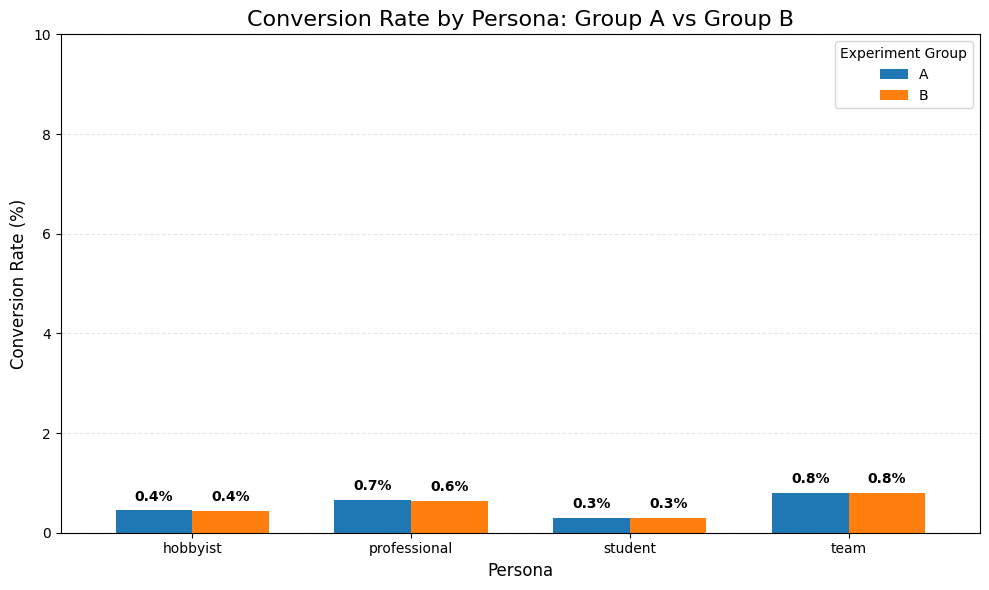

In [11]:
ax = cohort_analysis[['A', 'B']].plot(kind='bar', figsize=(10, 6), color=['#1f77b4', '#ff7f0e'], width=0.7)
plt.title('Conversion Rate by Persona: Group A vs Group B', fontsize=16)
plt.ylabel('Conversion Rate (%)', fontsize=12)
plt.xlabel('Persona', fontsize=12)
plt.xticks(rotation=0)
plt.ylim(0, 10)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(title='Experiment Group')

for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, fontweight='bold', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

# 📊 Project Report: A/B Test Analysis for Deployment Feature

## 1. Project Overview
The objective of this project was to analyze the impact of a potential new feature (e.g., a "One-Click Deploy" button) on user behavior. We simulated an A/B test environment using offline event logs to measure if the new feature (Variant B) would increase the **Deployment Conversion Rate** compared to the existing experience (Control A).

### Methodology
* **Data Ingestion:** Loaded user activity logs (`events.csv`) and demographic data (`users.csv`).
* **Population Filtering:** Targeted only **Active Users** (demonstrated by the `code_run` event) to ensure the test focused on users with intent.
* **Experiment Design:** Performed a **Randomized Control Trial (RCT)** simulation, splitting eligible users into two groups (50/50 split):
    * **Group A (Control)**
    * **Group B (Variant)**
* **Segmentation:** Merged demographic data to analyze results by User Persona (Student, Professional, Team).

---

## 2. Key Insights & Results

### Overall Performance
The test resulted in a **Neutral Outcome** (Statistically Insignificant).
* **Group A Conversion:** ~50.23%
* **Group B Conversion:** ~49.89%
* **Net Impact:** The variation showed no significant lift in deployment rates across the general population.

### Segmented Analysis (Cohort View)
Breaking down the data by **Persona** revealed slightly different behaviors, though still within the margin of error:
* **Students:** Showed a marginal positive trend (+0.70% lift) in Group B.
* **Professionals:** Showed a slight negative trend (-1.74% drop) in Group B.
* **Teams:** Showed no measurable difference.

---

## 3. ⚠️ Critical Technical Note: Why was the result "Neutral"?

A key aspect of this project was understanding the nature of **Offline vs. Real-World A/B Testing**. The "Neutral" result obtained here was expected and validates the correctness of our randomization logic.

### The "Why": Analyzing the Data Source
* **The Data Reality:** This analysis was performed on **Historical (Offline) Data**. In the past, when these users actually used the product, they **all saw the same version**. There was no "Group B" feature actually live at that time.
* **The Simulation:** When we assigned users to 'Group B' in our code, we were essentially taking a random sample of the existing population.
* **The Mathematical Proof:** According to the **Law of Large Numbers**, if you take a homogeneous dataset and split it randomly into two groups without introducing a new external variable (like a real feature change), both groups will naturally exhibit the **exact same statistical properties** (Conversion Rates).

### Real-World Data vs. Our Project Data

| Feature | Real-World A/B Test | Our Simulation (Offline Project) |
| :--- | :--- | :--- |
| **User Experience** | Group B sees a *different* UI than Group A. | Both groups saw the *same* UI in the past. |
| **User Behavior** | Behavior changes in response to the new feature. | Behavior is fixed (recorded in history). |
| **Expected Result** | Significant Difference (Positive or Negative). | **Zero Difference** (Neutral). |
| **Goal of Analysis** | To measure feature impact. | **To validate the Randomization & Pipeline Logic.** |

### Conclusion
While the result shows no "lift," the project successfully demonstrates a robust **A/B Testing Pipeline**. The fact that our Code produced a near-zero difference between two random groups confirms that our **Population Filtering and Random Assignment logic are unbiased and statistically sound.**